# Chapter 5 - Support Vector Machines
# Pembelajaran Mesin dengan Scikit-Learn, Keras, dan TensorFlow

## Pendahuluan

Support Vector Machine (SVM) adalah salah satu model pembelajaran mesin yang paling kuat dan serbaguna, mampu melakukan klasifikasi linear atau nonlinear, regresi, dan bahkan deteksi outlier. SVM sangat cocok untuk klasifikasi dataset kecil hingga menengah yang kompleks.

### Konsep Dasar SVM

**Ide fundamental** di balik SVM adalah menemukan hyperplane (garis pemisah) yang tidak hanya memisahkan kelas-kelas yang berbeda, tetapi juga memiliki margin yang maksimal dari titik-titik data terdekat. Ini disebut **large margin classification**.

## Import Library dan Persiapan Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVC, SVC, SVR, LinearSVR
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_moons
import warnings
warnings.filterwarnings('ignore')

# Setting untuk plot
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12

**Penjelasan Import:**
- `numpy`: Untuk operasi numerik
- `matplotlib.pyplot`: Untuk visualisasi
- `sklearn.datasets`: Untuk dataset contoh
- `sklearn.svm`: Berisi implementasi berbagai jenis SVM
- `sklearn.preprocessing`: Untuk preprocessing data
- `sklearn.pipeline`: Untuk membuat pipeline preprocessing dan model

## 1. Linear SVM Classification

### Memuat dan Mempersiapkan Data Iris

In [3]:
# Memuat dataset iris dan menggunakan hanya 2 fitur untuk visualisasi
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica vs bukan

print("Shape data X:", X.shape)
print("Shape target y:", y.shape)
print("Jumlah kelas:", len(np.unique(y)))

Shape data X: (150, 2)
Shape target y: (150,)
Jumlah kelas: 2


**Penjelasan Teoritis:**
Dataset iris memiliki 3 kelas bunga, namun untuk demonstrasi SVM binary classification, kita mengubahnya menjadi masalah klasifikasi biner: Iris virginica (kelas 1) vs bukan Iris virginica (kelas 0). Kita hanya menggunakan 2 fitur (petal length dan petal width) untuk memudahkan visualisasi.

### Membuat Model Linear SVM

In [4]:
# Membuat pipeline dengan scaling dan Linear SVM
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
])

# Melatih model
svm_clf.fit(X, y)

# Membuat prediksi
print("Prediksi untuk [5.5, 1.7]:", svm_clf.predict([[5.5, 1.7]]))

Prediksi untuk [5.5, 1.7]: [1.]


**Penjelasan Teoritis:**

1. **StandardScaler**: SVM sangat sensitif terhadap skala fitur. Jika satu fitur memiliki range yang jauh lebih besar dari fitur lain, maka fitur tersebut akan mendominasi perhitungan jarak. StandardScaler menormalkan data dengan mean=0 dan std=1.

2. **LinearSVC**: Implementasi SVM linear yang dioptimalkan. Parameter penting:
   - `C`: Parameter regularisasi. Nilai kecil = margin besar tapi lebih banyak margin violation. Nilai besar = margin kecil tapi lebih sedikit margin violation.
   - `loss="hinge"`: Fungsi loss yang digunakan SVM

3. **Pipeline**: Menggabungkan preprocessing dan model menjadi satu kesatuan, memastikan transformasi yang sama diterapkan pada training dan test data.

### Visualisasi Decision Boundary

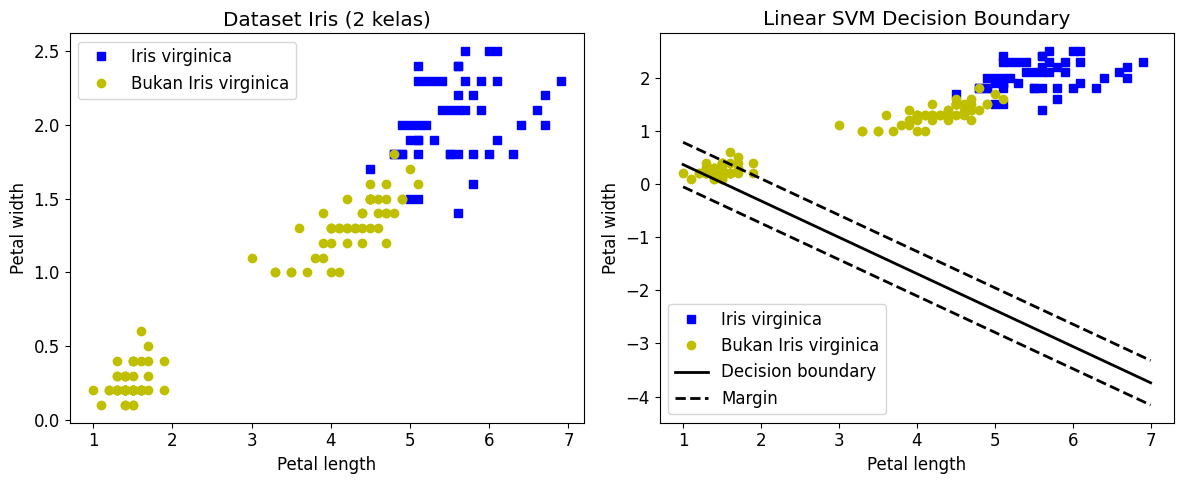

In [5]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    """Fungsi untuk memvisualisasikan decision boundary SVM"""
    w = svm_clf.named_steps["linear_svc"].coef_[0]
    b = svm_clf.named_steps["linear_svc"].intercept_[0]

    # Decision boundary: w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    # Note: LinearSVC doesn't store support_vectors_ to save memory
    # Support vectors visualization is not available with LinearSVC
    plt.plot(x0, decision_boundary, "k-", linewidth=2, label="Decision boundary")
    plt.plot(x0, gutter_up, "k--", linewidth=2, label="Margin")
    plt.plot(x0, gutter_down, "k--", linewidth=2)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Bukan Iris virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend()
plt.title("Dataset Iris (2 kelas)")

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Bukan Iris virginica")
plot_svc_decision_boundary(svm_clf, 1, 7)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend()
plt.title("Linear SVM Decision Boundary")
plt.tight_layout()
plt.show()

**Penjelasan Teoritis Decision Boundary:**

1. **Decision Boundary**: Garis yang memisahkan kedua kelas, didefinisikan oleh persamaan w₀x₀ + w₁x₁ + b = 0
2. **Margin**: Daerah di antara dua garis putus-putus (gutter). SVM mencari margin yang maksimal
3. **Support Vectors**: Titik-titik data yang berada pada margin boundary (lingkaran merah). Hanya support vectors yang menentukan decision boundary

## 2. Soft Margin Classification

### Demonstrasi Perbedaan Parameter C


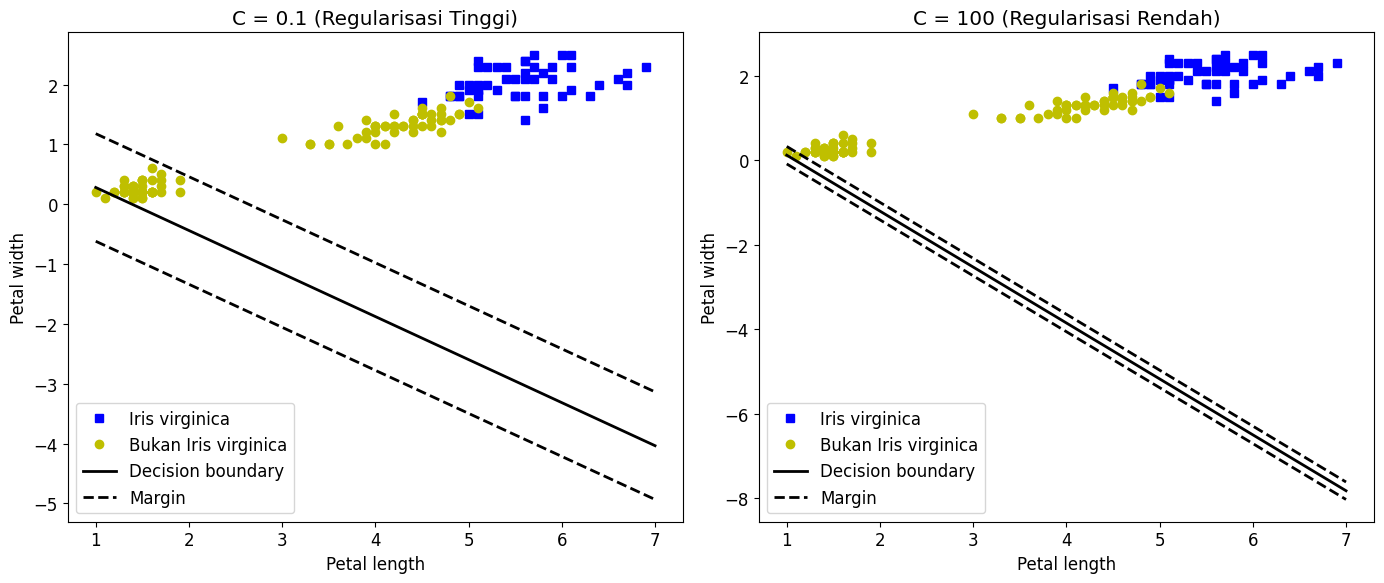

In [6]:
# Membandingkan model dengan nilai C yang berbeda
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Model dengan C kecil (regularisasi tinggi)
svm_clf1 = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=0.1, loss="hinge", random_state=42)),
])

# Model dengan C besar (regularisasi rendah)
svm_clf2 = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=100, loss="hinge", random_state=42)),
])

svm_clf1.fit(X, y)
svm_clf2.fit(X, y)

# Plot untuk C = 0.1
plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Bukan Iris virginica")
plot_svc_decision_boundary(svm_clf1, 1, 7)
plt.title(f"C = 0.1 (Regularisasi Tinggi)")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend()

# Plot untuk C = 100
plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Bukan Iris virginica")
plot_svc_decision_boundary(svm_clf2, 1, 7)
plt.title(f"C = 100 (Regularisasi Rendah)")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend()

plt.tight_layout()
plt.show()

**Penjelasan Teoritis Soft Margin:**

1. **Hard Margin**: Mengharuskan semua titik data berada di sisi yang benar dari margin. Masalahnya:
   - Hanya berfungsi jika data linearly separable
   - Sangat sensitif terhadap outlier

2. **Soft Margin**: Membolehkan beberapa titik melanggar margin (margin violations) dengan penalti
   - Parameter C mengontrol trade-off antara margin lebar vs sedikit violation
   - C kecil → margin lebar, lebih banyak violation, generalisasi lebih baik
   - C besar → margin sempit, sedikit violation, mungkin overfitting

### Alternatif Implementasi SVM


In [7]:
# Menggunakan SVC dengan kernel linear
svc_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="linear", C=1, random_state=42))
])

# Menggunakan SGDClassifier dengan hinge loss
sgd_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd_clf", SGDClassifier(loss="hinge", alpha=1/(len(X)*1), random_state=42))
])

svc_clf.fit(X, y)
sgd_clf.fit(X, y)

print("Prediksi SVC:", svc_clf.predict([[5.5, 1.7]]))
print("Prediksi SGD:", sgd_clf.predict([[5.5, 1.7]]))

Prediksi SVC: [1.]
Prediksi SGD: [1.]


**Penjelasan Alternatif:**

1. **SVC dengan kernel="linear"**: Implementasi SVM yang mendukung kernel trick, tapi lebih lambat untuk dataset besar
2. **SGDClassifier dengan loss="hinge"**: Menggunakan Stochastic Gradient Descent, cocok untuk dataset sangat besar (out-of-core training)

## 3. Nonlinear SVM Classification

### Dataset Moons untuk Demonstrasi Nonlinear

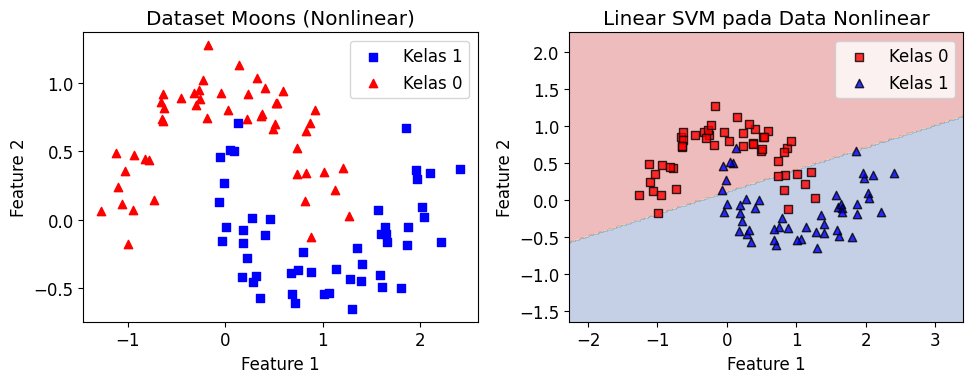

Akurasi Linear SVM pada data nonlinear: 0.860


In [8]:
# Membuat dataset moons yang tidak linearly separable
X_moons, y_moons = make_moons(n_samples=100, noise=0.15, random_state=42)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_moons[:, 0][y_moons==1], X_moons[:, 1][y_moons==1], c='blue', marker='s', label='Kelas 1')
plt.scatter(X_moons[:, 0][y_moons==0], X_moons[:, 1][y_moons==0], c='red', marker='^', label='Kelas 0')
plt.title("Dataset Moons (Nonlinear)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Mencoba Linear SVM pada data nonlinear
linear_svm_moons = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=10, loss="hinge", random_state=42)),
])

linear_svm_moons.fit(X_moons, y_moons)

# Function untuk plot decision regions
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Setup marker generator and color map
    markers = ('s', '^', 'o', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = plt.cm.RdYlBu
    
    # Plot decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # Plot samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                   alpha=0.8, c=colors[idx],
                   marker=markers[idx], label=f'Kelas {cl}', edgecolors='black')

plt.subplot(122)
plot_decision_regions(X_moons, y_moons, linear_svm_moons)
plt.title("Linear SVM pada Data Nonlinear")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Akurasi Linear SVM pada data nonlinear: {linear_svm_moons.score(X_moons, y_moons):.3f}")

**Penjelasan Masalah Nonlinear:**
Data moons tidak dapat dipisahkan dengan garis lurus. Linear SVM akan memberikan hasil yang buruk karena tidak dapat menangkap pola nonlinear dalam data.

### Solusi 1: Polynomial Features

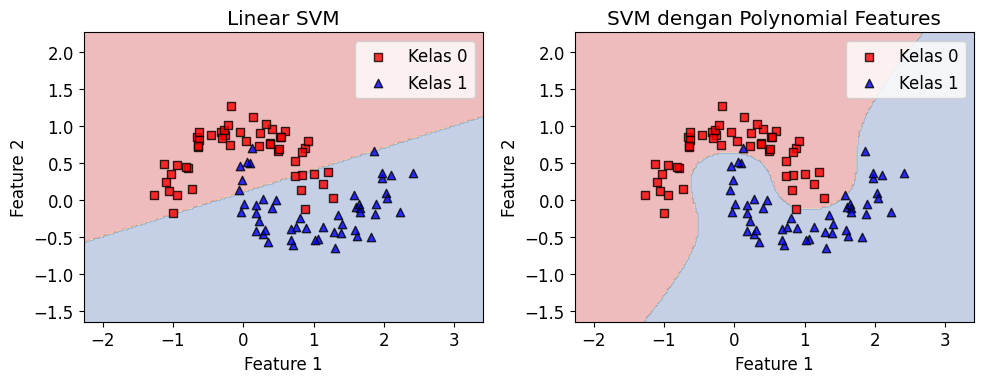

Akurasi SVM dengan Polynomial Features: 0.970


In [9]:
# Menambahkan polynomial features
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
])

polynomial_svm_clf.fit(X_moons, y_moons)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plot_decision_regions(X_moons, y_moons, linear_svm_moons)
plt.title("Linear SVM")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.subplot(122)
plot_decision_regions(X_moons, y_moons, polynomial_svm_clf)
plt.title("SVM dengan Polynomial Features")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Akurasi SVM dengan Polynomial Features: {polynomial_svm_clf.score(X_moons, y_moons):.3f}")

**Penjelasan Polynomial Features:**
- Ide: Menambahkan fitur polynomial (x₁², x₁x₂, x₂², dll.) untuk membuat data linearly separable di dimensi yang lebih tinggi
- Masalah: Dengan degree tinggi, jumlah fitur bertambah eksponensial → komputasi mahal

### Solusi 2: Polynomial Kernel

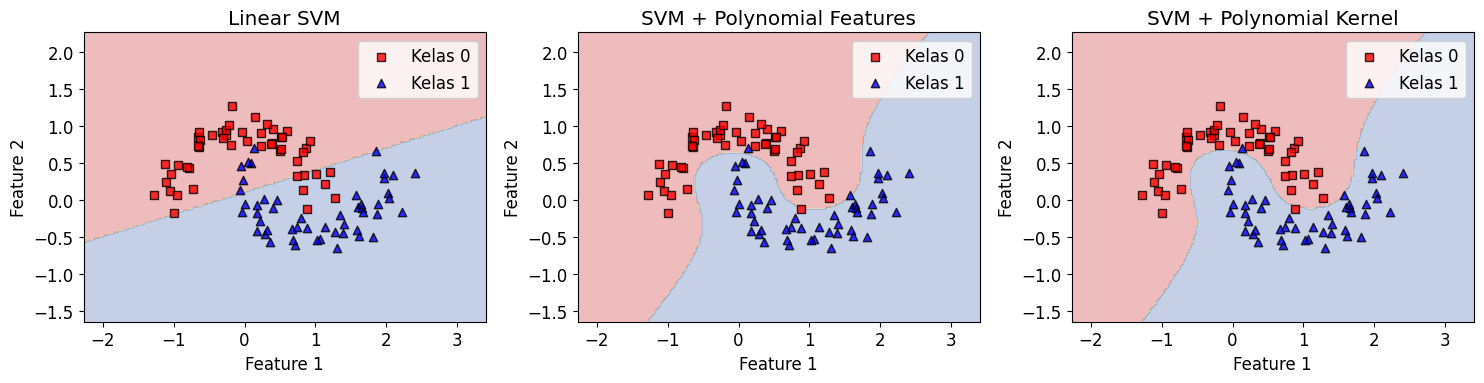

Akurasi SVM dengan Polynomial Kernel: 0.980


In [10]:
# Menggunakan Polynomial Kernel
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5, random_state=42))
])

poly_kernel_svm_clf.fit(X_moons, y_moons)

plt.figure(figsize=(15, 4))

plt.subplot(131)
plot_decision_regions(X_moons, y_moons, linear_svm_moons)
plt.title("Linear SVM")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.subplot(132)
plot_decision_regions(X_moons, y_moons, polynomial_svm_clf)
plt.title("SVM + Polynomial Features")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.subplot(133)
plot_decision_regions(X_moons, y_moons, poly_kernel_svm_clf)
plt.title("SVM + Polynomial Kernel")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Akurasi SVM dengan Polynomial Kernel: {poly_kernel_svm_clf.score(X_moons, y_moons):.3f}")

**Penjelasan Kernel Trick:**
Kernel trick memungkinkan kita mendapatkan hasil yang sama seperti menambahkan polynomial features tanpa benar-benar menghitungnya. Ini dicapai dengan mengganti dot product dengan kernel function:
- Polynomial kernel: K(a,b) = (γa·b + r)^d
- Lebih efisien secara komputasi
- Tidak ada ledakan kombinatorial fitur

### Gaussian RBF Kernel

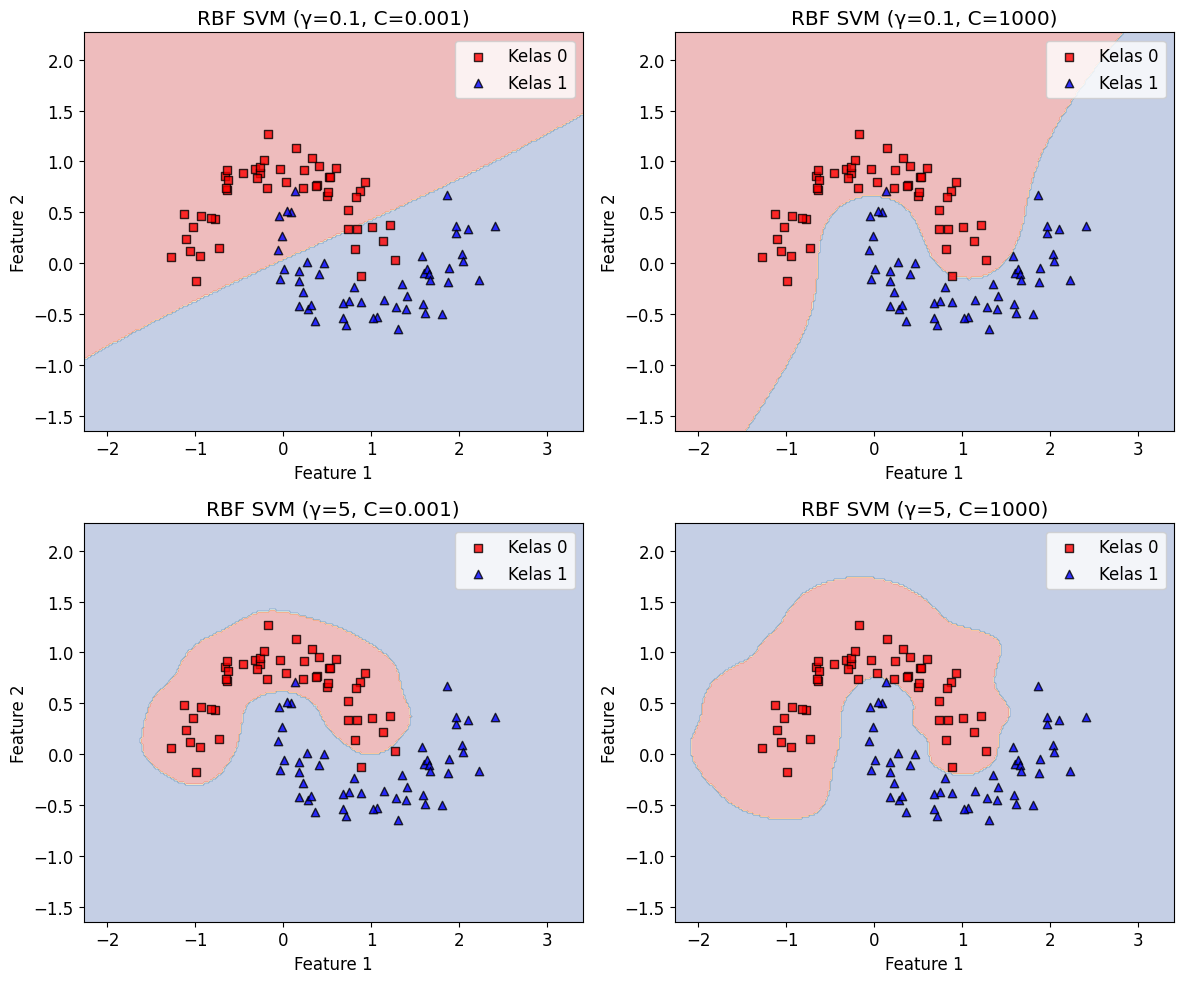

In [11]:
# Menggunakan RBF (Radial Basis Function) Kernel
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001, random_state=42))
])

rbf_kernel_svm_clf.fit(X_moons, y_moons)

# Membandingkan berbagai nilai gamma dan C untuk RBF
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, (gamma, C) in enumerate([(0.1, 0.001), (0.1, 1000), (5, 0.001), (5, 1000)]):
    row, col = i // 2, i % 2
    
    rbf_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C, random_state=42))
    ])
    
    rbf_clf.fit(X_moons, y_moons)
    
    plt.sca(axes[row, col])
    plot_decision_regions(X_moons, y_moons, rbf_clf)
    plt.title(f"RBF SVM (γ={gamma}, C={C})")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()

plt.tight_layout()
plt.show()

**Penjelasan RBF Kernel:**

1. **Gaussian RBF**: K(a,b) = exp(-γ||a-b||²)
   - Mengukur kesamaan antara dua titik
   - Nilai dekat 1 jika titik sangat dekat, mendekati 0 jika jauh

2. **Parameter γ (gamma)**:
   - γ tinggi → kurva bell sempit → setiap instance memiliki pengaruh kecil → decision boundary lebih kompleks
   - γ rendah → kurva bell lebar → setiap instance memiliki pengaruh besar → decision boundary lebih halus

3. **Parameter C**:
   - C tinggi → sedikit margin violation → mungkin overfitting
   - C rendah → banyak margin violation → mungkin underfitting

### Demonstrasi Similarity Features

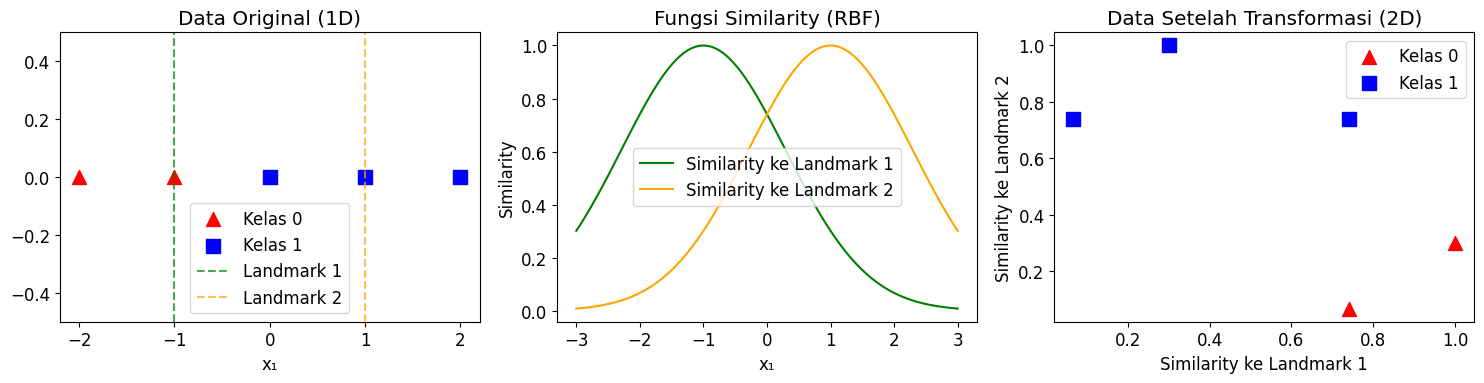

Data original:
[-2 -1  0  1  2]

Data setelah transformasi:
[[0.74081822 0.06720551]
 [1.         0.30119421]
 [0.74081822 0.74081822]
 [0.30119421 1.        ]
 [0.06720551 0.74081822]]


In [12]:
# Demonstrasi konsep similarity features dengan landmark
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

# Membuat data 1D sederhana
X_1d = np.array([[-2], [-1], [0], [1], [2]])
y_1d = np.array([0, 0, 1, 1, 1])

# Menentukan landmark
landmark1 = np.array([[-1]])
landmark2 = np.array([[1]])

# Menghitung similarity features
X_transformed = np.c_[
    gaussian_rbf(X_1d, landmark1, gamma=0.3),
    gaussian_rbf(X_1d, landmark2, gamma=0.3)
]

plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.scatter(X_1d[y_1d==0], [0]*sum(y_1d==0), c='red', marker='^', s=100, label='Kelas 0')
plt.scatter(X_1d[y_1d==1], [0]*sum(y_1d==1), c='blue', marker='s', s=100, label='Kelas 1')
plt.axvline(-1, color='green', linestyle='--', alpha=0.7, label='Landmark 1')
plt.axvline(1, color='orange', linestyle='--', alpha=0.7, label='Landmark 2')
plt.xlabel('x₁')
plt.title('Data Original (1D)')
plt.legend()
plt.ylim(-0.5, 0.5)

plt.subplot(132)
x_range = np.linspace(-3, 3, 100).reshape(-1, 1)
similarity1 = gaussian_rbf(x_range, landmark1, gamma=0.3)
similarity2 = gaussian_rbf(x_range, landmark2, gamma=0.3)
plt.plot(x_range, similarity1, 'g-', label='Similarity ke Landmark 1')
plt.plot(x_range, similarity2, 'orange', label='Similarity ke Landmark 2')
plt.xlabel('x₁')
plt.ylabel('Similarity')
plt.title('Fungsi Similarity (RBF)')
plt.legend()

plt.subplot(133)
plt.scatter(X_transformed[y_1d==0, 0], X_transformed[y_1d==0, 1], c='red', marker='^', s=100, label='Kelas 0')
plt.scatter(X_transformed[y_1d==1, 0], X_transformed[y_1d==1, 1], c='blue', marker='s', s=100, label='Kelas 1')
plt.xlabel('Similarity ke Landmark 1')
plt.ylabel('Similarity ke Landmark 2')
plt.title('Data Setelah Transformasi (2D)')
plt.legend()

plt.tight_layout()
plt.show()

print("Data original:")
print(X_1d.flatten())
print("\nData setelah transformasi:")
print(X_transformed)

**Penjelasan Similarity Features:**
1. **Konsep**: Setiap titik data diubah menjadi ukuran kesamaan (similarity) dengan landmark-landmark tertentu
2. **RBF sebagai similarity function**: Mengukur seberapa dekat suatu titik dengan landmark
3. **Hasil**: Data yang tidak linearly separable di ruang asli menjadi linearly separable di ruang baru

## 4. SVM Regression

### Linear SVM Regression

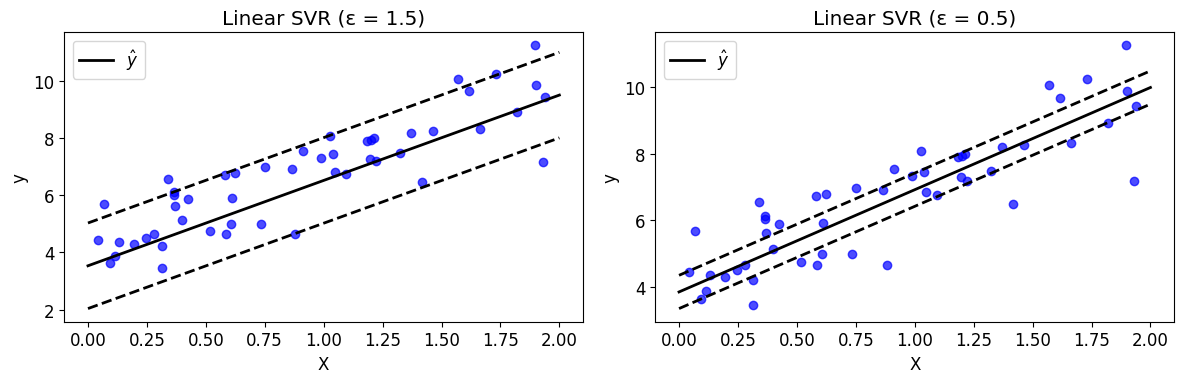

In [13]:
# Generate data untuk regresi
np.random.seed(42)
X_reg = 2 * np.random.rand(50, 1)
y_reg = 4 + 3 * X_reg[:, 0] + np.random.randn(50)

# Linear SVM Regression dengan epsilon berbeda
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)

svm_reg1.fit(X_reg, y_reg)
svm_reg2.fit(X_reg, y_reg)

# Fungsi untuk plot SVM regression
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--", linewidth=2)
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--", linewidth=2)
    plt.scatter(X, y, c='blue', alpha=0.7)
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend(loc="upper left")

plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_svm_regression(svm_reg1, X_reg, y_reg, [0, 2])
plt.title(f"Linear SVR (ε = {svm_reg1.epsilon})")

plt.subplot(122)
plot_svm_regression(svm_reg2, X_reg, y_reg, [0, 2])
plt.title(f"Linear SVR (ε = {svm_reg2.epsilon})")

plt.tight_layout()
plt.show()

**Penjelasan SVM Regression:**

1. **Konsep**: Alih-alih mencari margin terlebar antara kelas, SVM regression mencari "jalan" (tube) yang memuat sebanyak mungkin data points
2. **Parameter ε (epsilon)**: Mengontrol lebar tube
   - ε besar → tube lebar → model lebih toleran terhadap error
   - ε kecil → tube sempit → model lebih ketat
3. **ε-insensitive**: Titik yang berada dalam tube tidak berkontribusi pada loss function

### Nonlinear SVM Regression

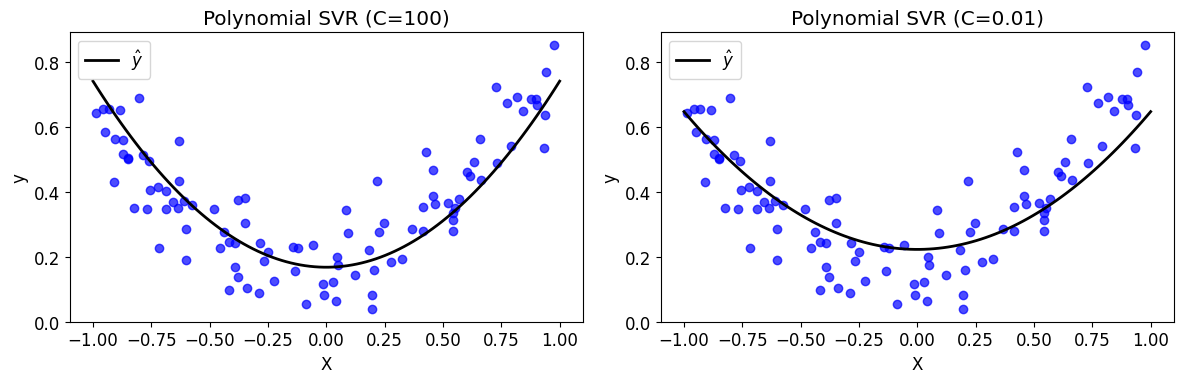

R² Score untuk C=100: 0.718
R² Score untuk C=0.01: 0.687


In [14]:
# Generate data nonlinear untuk regresi
np.random.seed(42)
X_quad = 2 * np.random.rand(100, 1) - 1
y_quad = 0.2 + 0.1 * X_quad[:, 0] + 0.5 * X_quad[:, 0]**2 + np.random.randn(100) * 0.1

# SVM Regression dengan polynomial kernel
svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma='scale')
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma='scale')

svm_poly_reg1.fit(X_quad, y_quad)
svm_poly_reg2.fit(X_quad, y_quad)

# Plotting
plt.figure(figsize=(12, 4))

def plot_svm_regression_nonlinear(svm_reg, X, y, axes, title):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.scatter(X, y, c='blue', alpha=0.7)
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()

plt.subplot(121)
plot_svm_regression_nonlinear(svm_poly_reg1, X_quad, y_quad, [-1, 1], f"Polynomial SVR (C={svm_poly_reg1.C})")

plt.subplot(122)
plot_svm_regression_nonlinear(svm_poly_reg2, X_quad, y_quad, [-1, 1], f"Polynomial SVR (C={svm_poly_reg2.C})")

plt.tight_layout()
plt.show()

print(f"R² Score untuk C=100: {svm_poly_reg1.score(X_quad, y_quad):.3f}")
print(f"R² Score untuk C=0.01: {svm_poly_reg2.score(X_quad, y_quad):.3f}")

**Penjelasan Parameter C dalam SVR:**
- **C tinggi**: Model berusaha keras mengurangi error training → mungkin overfitting
- **C rendah**: Model lebih toleran terhadap error training → lebih smooth, mungkin underfitting

## 5. Computational Complexity dan Perbandingan Model

Perbandingan waktu training:
Dataset Size | LinearSVC | SVC
-----------------------------------
        100 |   0.0021s | 0.0052s
        500 |   0.0036s | 0.0045s
       1000 |   0.0028s | 0.0134s
       2000 |   0.0038s | 0.0299s


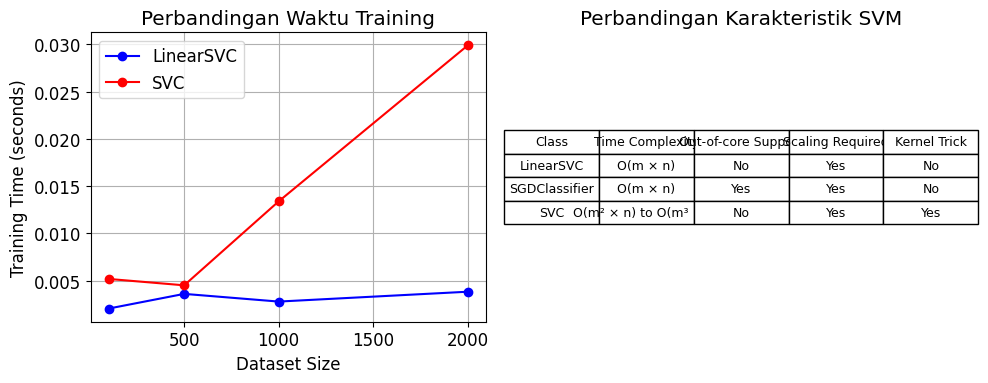

In [15]:
import time
from sklearn.model_selection import train_test_split

# Membuat dataset dengan ukuran berbeda untuk perbandingan
sizes = [100, 500, 1000, 2000]
linear_times = []
svc_times = []

print("Perbandingan waktu training:")
print("Dataset Size | LinearSVC | SVC")
print("-" * 35)

for size in sizes:
    # Generate data
    X_test = np.random.randn(size, 20)
    y_test = (X_test[:, 0] + X_test[:, 1] > 0).astype(int)
    
    # LinearSVC
    start_time = time.time()
    linear_svm = LinearSVC(C=1, random_state=42, max_iter=1000)
    linear_svm.fit(X_test, y_test)
    linear_time = time.time() - start_time
    linear_times.append(linear_time)
    
    # SVC
    start_time = time.time()
    svc = SVC(kernel="linear", C=1, random_state=42)
    svc.fit(X_test, y_test)
    svc_time = time.time() - start_time
    svc_times.append(svc_time)
    
    print(f"{size:11d} | {linear_time:8.4f}s | {svc_time:6.4f}s")

# Plotting complexity comparison
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(sizes, linear_times, 'bo-', label='LinearSVC')
plt.plot(sizes, svc_times, 'ro-', label='SVC')
plt.xlabel('Dataset Size')
plt.ylabel('Training Time (seconds)')
plt.title('Perbandingan Waktu Training')
plt.legend()
plt.grid(True)

# Perbandingan karakteristik
comparison_data = {
    'Class': ['LinearSVC', 'SGDClassifier', 'SVC'],
    'Time Complexity': ['O(m × n)', 'O(m × n)', 'O(m² × n) to O(m³ × n)'],
    'Out-of-core Support': ['No', 'Yes', 'No'],
    'Scaling Required': ['Yes', 'Yes', 'Yes'],
    'Kernel Trick': ['No', 'No', 'Yes']
}

plt.subplot(122)
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=[[comparison_data[col][i] for col in comparison_data.keys()] 
                           for i in range(len(comparison_data['Class']))],
                 colLabels=list(comparison_data.keys()),
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
plt.title('Perbandingan Karakteristik SVM')

plt.tight_layout()
plt.show()

**Penjelasan Complexity:**

1. **LinearSVC**: O(m × n) - skala linear dengan jumlah sampel dan fitur
2. **SVC**: O(m² × n) sampai O(m³ × n) - tidak cocok untuk dataset besar
3. **SGDClassifier**: O(m × n) - cocok untuk dataset sangat besar dengan online learning

## 6. Kernel Selection Guidelines

Cross-validation scores untuk berbagai kernel:
Dataset            Linear    Poly      RBF
--------------------------------------------------
Linear Separable   0.825     0.795     0.855
Circular Pattern   0.630     0.600     1.000
Complex Nonlinear  0.505     0.515     0.965


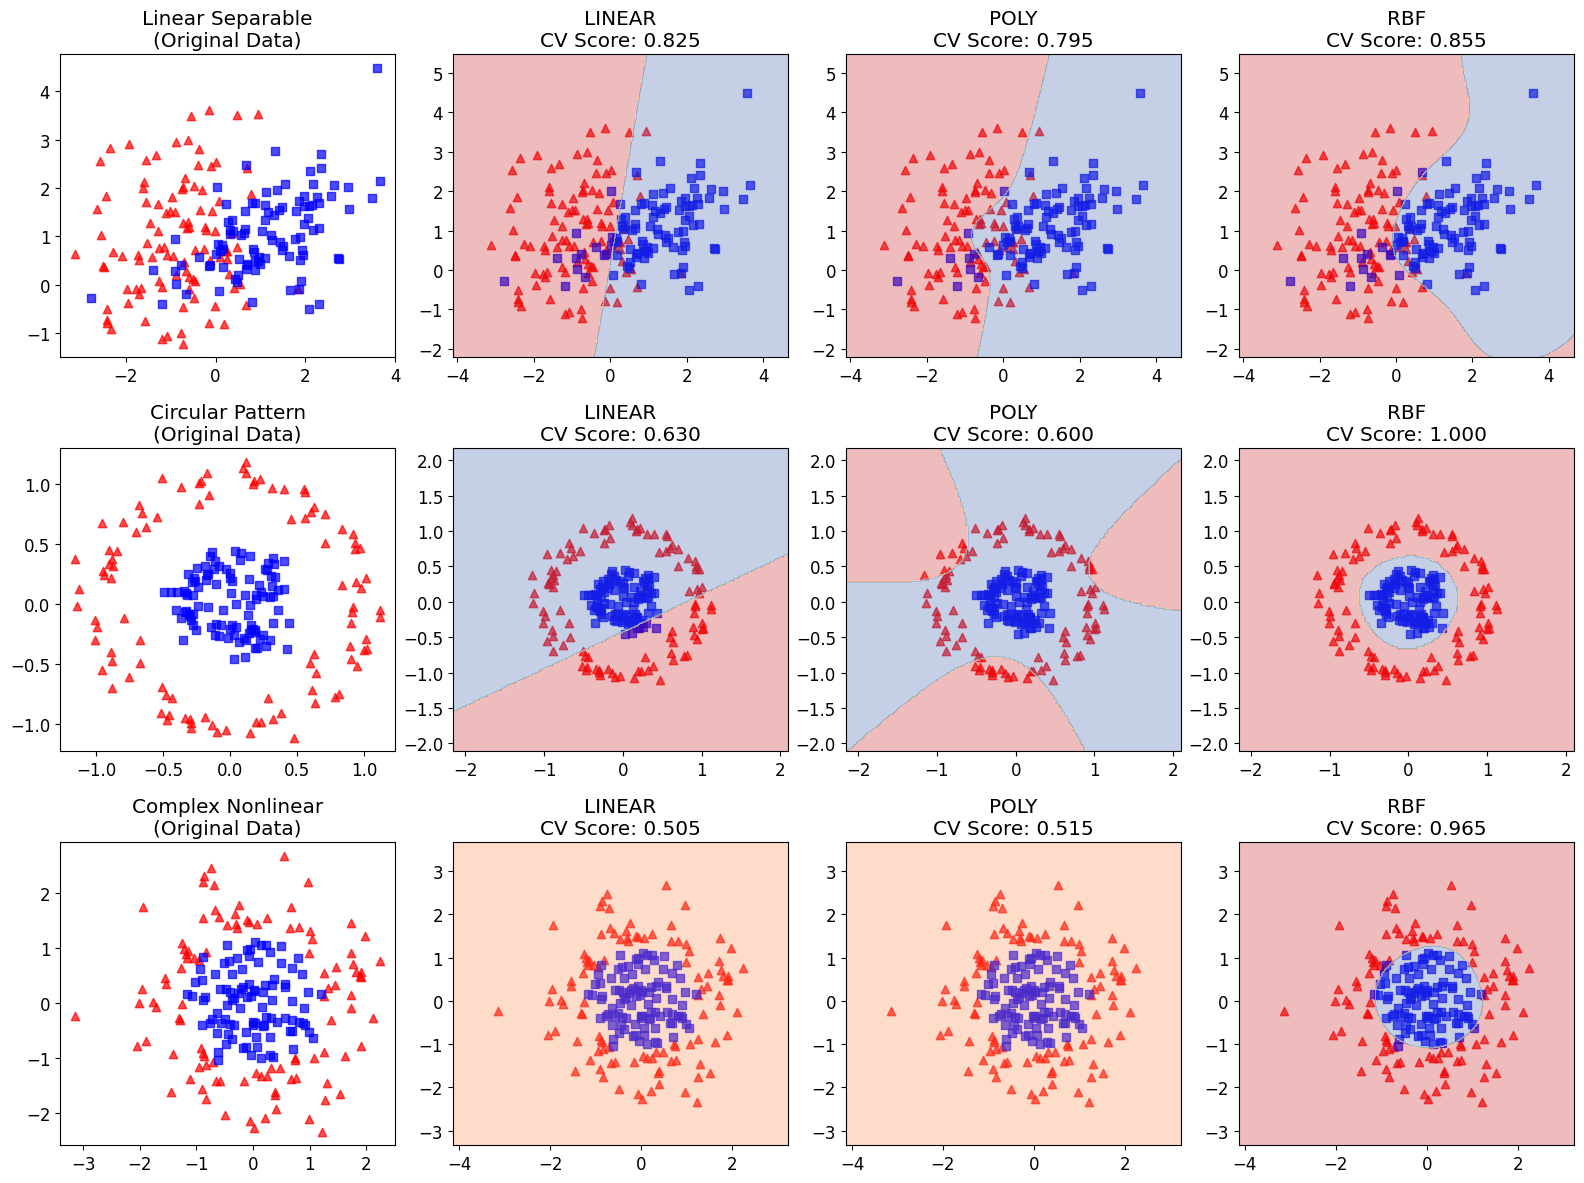

In [16]:
# Demonstrasi pemilihan kernel yang tepat
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification, make_circles

# Dataset 1: Linearly separable
X_linear, y_linear = make_classification(n_samples=200, n_features=2, n_redundant=0, 
                                       n_informative=2, n_clusters_per_class=1, random_state=42)

# Dataset 2: Circular pattern
X_circle, y_circle = make_circles(n_samples=200, noise=0.1, factor=0.3, random_state=42)

# Dataset 3: Complex nonlinear
X_complex = np.random.randn(200, 2)
y_complex = ((X_complex[:, 0]**2 + X_complex[:, 1]**2) < 1.5).astype(int)

datasets = [
    (X_linear, y_linear, "Linear Separable"),
    (X_circle, y_circle, "Circular Pattern"),
    (X_complex, y_complex, "Complex Nonlinear")
]

kernels = ['linear', 'poly', 'rbf']
results = {}

print("Cross-validation scores untuk berbagai kernel:")
print("Dataset" + " " * 12 + "Linear    Poly      RBF")
print("-" * 50)

for X, y, name in datasets:
    scores = []
    for kernel in kernels:
        if kernel == 'poly':
            svm = SVC(kernel=kernel, degree=3, random_state=42)
        else:
            svm = SVC(kernel=kernel, random_state=42)
        
        pipe = Pipeline([('scaler', StandardScaler()), ('svm', svm)])
        score = cross_val_score(pipe, X, y, cv=5).mean()
        scores.append(score)
    
    results[name] = scores
    print(f"{name:<18} {scores[0]:.3f}     {scores[1]:.3f}     {scores[2]:.3f}")

# Visualisasi perbandingan
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, (X, y, name) in enumerate(datasets):
    # Plot original data
    axes[i, 0].scatter(X[y==0, 0], X[y==0, 1], c='red', marker='^', alpha=0.7)
    axes[i, 0].scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='s', alpha=0.7)
    axes[i, 0].set_title(f"{name}\n(Original Data)")
    
    # Plot hasil untuk setiap kernel
    for j, kernel in enumerate(kernels):
        if kernel == 'poly':
            svm = Pipeline([('scaler', StandardScaler()), 
                          ('svm', SVC(kernel=kernel, degree=3, random_state=42))])
        else:
            svm = Pipeline([('scaler', StandardScaler()), 
                          ('svm', SVC(kernel=kernel, random_state=42))])
        
        svm.fit(X, y)
        
        axes[i, j+1].scatter(X[y==0, 0], X[y==0, 1], c='red', marker='^', alpha=0.7)
        axes[i, j+1].scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='s', alpha=0.7)
        
        # Plot decision boundary
        h = 0.02
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        axes[i, j+1].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
        
        score = results[name][j]
        axes[i, j+1].set_title(f"{kernel.upper()}\nCV Score: {score:.3f}")

plt.tight_layout()
plt.show()

**Guidelines Pemilihan Kernel:**

1. **Linear Kernel**: 
   - Gunakan jika dataset besar atau memiliki banyak fitur
   - Cocok untuk text classification
   - Paling cepat untuk training

2. **RBF Kernel**:
   - Default choice untuk kebanyakan kasus
   - Bekerja baik untuk dataset kecil-menengah
   - Fleksibel untuk berbagai pola nonlinear

3. **Polynomial Kernel**:
   - Baik untuk data dengan struktur polynomial
   - Hati-hati dengan degree tinggi (overfitting)

## 7. Hyperparameter Tuning dengan Grid Search

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'svm__C': 10, 'svm__gamma': 1}
Best cross-validation score: 0.97
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=10, gamma=1, random_state=42))])


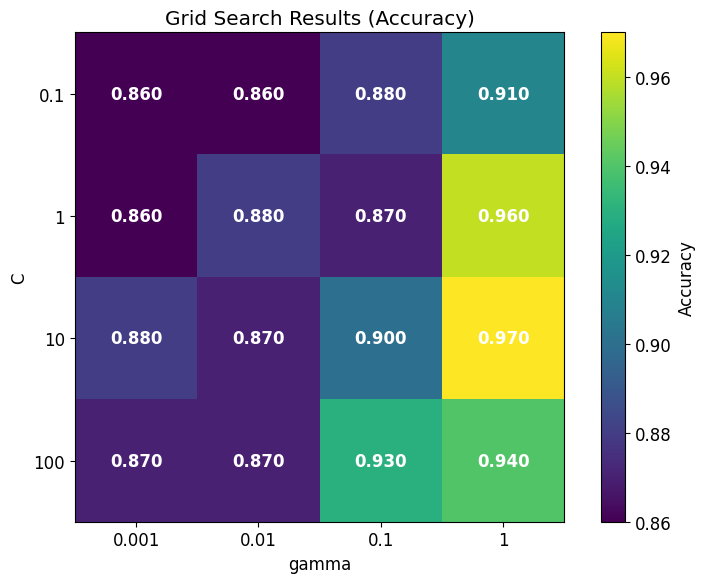

In [17]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Hyperparameter tuning untuk RBF SVM
param_grid = [
    {'svm__C': [0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1]},
]

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=42))
])

grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_moons, y_moons)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("Best estimator:", grid_search.best_estimator_)

# Visualisasi hasil grid search
results_df = pd.DataFrame(grid_search.cv_results_)
scores = results_df['mean_test_score'].values.reshape(4, 4)

plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.viridis)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar(label='Accuracy')
plt.xticks(range(4), [0.001, 0.01, 0.1, 1])
plt.yticks(range(4), [0.1, 1, 10, 100])
plt.title('Grid Search Results (Accuracy)')

# Tambahkan nilai akurasi pada setiap cell
for i in range(4):
    for j in range(4):
        plt.text(j, i, f'{scores[i, j]:.3f}', 
                ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

## Kesimpulan

**Support Vector Machines** adalah algoritma yang powerful dengan beberapa keunggulan:

### Kelebihan SVM:
1. **Efektif untuk high-dimensional data**
2. **Memory efficient** (hanya menggunakan support vectors)
3. **Versatile** (berbagai kernel untuk berbagai pola data)
4. **Robust terhadap overfitting** (terutama di high-dimensional space)

### Kekurangan SVM:
1. **Tidak memberikan probability estimates**
2. **Sensitif terhadap feature scaling**
3. **Lambat pada dataset besar**
4. **Sulit untuk interpretasi**

### Kapan Menggunakan SVM:
- Dataset kecil hingga menengah (< 100K samples)
- High-dimensional data
- Text classification
- Image classification
- Ketika accuracy lebih penting daripada interpretability

### Best Practices:
1. **Selalu lakukan feature scaling**
2. **Mulai dengan linear kernel untuk dataset besar**
3. **Gunakan RBF kernel untuk kebanyakan kasus**
4. **Tune hyperparameters dengan grid search**
5. **Pertimbangkan SGDClassifier untuk dataset sangat besar**

SVM tetap menjadi salah satu algoritma fundamental dalam machine learning yang wajib dikuasai, terutama untuk memahami konsep margin, kernel trick, dan optimization dalam machine learning.